In [78]:
import pyreadstat
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [79]:
# a function to compute deferral rates and make a 2X2 table

def make_table(df):
    first=df.query("first_time == 1")
    repeat=df.query("first_time == 0")
    
    #create a dict
    table={}
    table['-']=['Female', 'Male', 'All']

        #first time
    female=(len(first.loc[(first.DONOR_GENDER == 'F') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.DONOR_GENDER == 'F')]))
    male=(len(first.loc[(first.DONOR_GENDER == 'M') & (first.OUTCOME_TYPE=='low hgb')])/len(first.loc[(first.DONOR_GENDER == 'M')]))
    alls=(len(first.loc[(first.OUTCOME_TYPE=='low hgb')])/len(first))
    table['First Time']=[female, male, alls]

        #repeat
    female=(len(repeat.loc[(repeat.DONOR_GENDER == 'F') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.DONOR_GENDER == 'F')]))
    male=(len(repeat.loc[(repeat.DONOR_GENDER == 'M') & (repeat.OUTCOME_TYPE=='low hgb')])/len(repeat.loc[(repeat.DONOR_GENDER == 'M')]))
    alls=(len(repeat.loc[(repeat.OUTCOME_TYPE=='low hgb')])/len(repeat))
    table['Repeat']=[female, male, alls]

        #all 
    female=(len(df.loc[(df.DONOR_GENDER == 'F') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.DONOR_GENDER == 'F')]))
    male=(len(df.loc[(df.DONOR_GENDER == 'M') & (df.OUTCOME_TYPE=='low hgb')])/len(df.loc[(df.DONOR_GENDER == 'M')]))
    alls=(len(df.loc[(df.OUTCOME_TYPE=='low hgb')])/len(df))
    table['All']=[female, male, alls]
    table=pd.DataFrame(table)
    
    return table
    


In [130]:
#load relevant data
don=pd.read_csv("../1_data/private/donation_donor.csv") #donations
defr=pd.read_csv("../1_data/private/deferral.csv") #deferrals
med_quest=pd.read_csv("../1_data/private/medical_quest.csv") #hgb value

In [95]:
med_questHGB=med_quest.loc[(med_quest['QUESTION_CODE']=='5U')] #df with hgb values
med_questHGB_recheck=med_quest.loc[(med_quest['QUESTION_CODE']=='5V')] #df with hgb recheck values

In [98]:
#med_quest.sort_values(by=['DONOR_NUMBER', 'DON_DATE_KEY'], axis = 0, inplace=True)

#med_quest.tail(50)

In [96]:
print(len(med_questHGB))
print(len(med_questHGB_recheck))
#define hgb value-> if recheck if not na replace hgb value with recheck value
m=pd.merge(med_questHGB[["DONOR_NUMBER", "DON_DATE_KEY", "DONATION_NUMBER", 'MQ_ANSWER']], med_questHGB_recheck[["DONOR_NUMBER", "DON_DATE_KEY", "DONATION_NUMBER", 'MQ_ANSWER']], how='left', on=['DONATION_NUMBER']) 

m['HGB_value']=np.where((m.MQ_ANSWER_y.notna()), m.MQ_ANSWER_y, m.MQ_ANSWER_x)

m['HGB_value']=pd.to_numeric(m['HGB_value'], errors='coerce')
m['HGB_value'].replace(np.nan, 999, regex=True, inplace=True)
m.DON_DATE_KEY_x=pd.to_numeric(m.DON_DATE_KEY_x)
m=m.loc[m.DON_DATE_KEY>=20170101.0]


9071135
333131


53213

In [128]:
#don=don2 #uncomment and run to reset

In [131]:
don2=don #duplicate before making changes

#filter out unrequired donation froms donations table
print(len(don))
#drop unknown keys and donor numbers
#drop missing dates
don.drop(don[(don['DONOR_NUMBER'] == 'UNKNOWN')].index, inplace=True)
don.drop(don[(don['DONOR_KEY'] == 0.0)].index, inplace=True)
don.drop(don[don.DON_DATE_KEY.isna()].index, inplace=True)

#2017-2022
don["Visit_Date"] = pd.to_datetime(don['DON_DATE_KEY'], format='%Y%m%d') #convert to datetime object
don['Year'] = don['Visit_Date'].dt.year 
mask = (don['Year'] >= 2017) 
don = don.loc[mask]

# Allogenic only
don.drop(don[(don['DONATION_TYPE'] == 'Therapeutic')].index, inplace=True)

#rbc and Wb only
don.drop(don[(don['PHLEBOTOMY_GROUP'] != 'Whole Blood') & (don['PHLEBOTOMY_GROUP'] != 'RBCP') &
          (don['PHLEBOTOMY_GROUP'] != 'Platelet/RBC/Plasma') & (don['PHLEBOTOMY_GROUP'] != 'Platelet/RBC')].index, inplace=True)


#remove FINs that are still in the process if migrating
don['FIN']=don.DONATION_NUMBER.str.slice(start=0, stop=5)
don.drop(don[(don['FIN'] == 'W0358') |
             (don['FIN'] == 'W0364') |
             (don['FIN'] == 'W0433') |
             (don['FIN'] == 'W2864') |
             (don['FIN'] == 'W2865') |
             (don['FIN'] == 'W2868') |
             (don['FIN'] == 'W2869') |
             (don['FIN'] == 'W2870') |
             (don['FIN'] == 'W2873') |
             (don['FIN'] == 'W2874') |
             (don['FIN'] == 'W2875') |
             (don['FIN'] == 'W2876') |
             (don['FIN'] == 'W2877') |
             (don['FIN'] == 'W2878') |
             (don['FIN'] == 'W2879') |
             (don['FIN'] == 'W2880') |
             (don['FIN'] == 'W2881') |
             (don['FIN'] == 'W2882') |
             (don['FIN'] == 'W2883') |
             (don['FIN'] == 'W2884') |
             (don['FIN'] == 'W2885') |
             (don['FIN'] == 'W2886') ].index, inplace=True)

len(don)

15865355


4894800

In [50]:
#defr=defr2# uncomment to reset

In [133]:
#shrink deferral table
defr2=defr
print(len(defr))
# drop don date and remove duplicates
#defr=defr2.drop(['DON_DATE_KEY'], axis=1)
#defr.drop_duplicates(inplace=True)
#print(len(defr))

88854867


In [134]:
#change deferral start_date to don_date_key
defr['old_date_key']=defr['DON_DATE_KEY']#save don date key in differnt column
defr['DON_DATE_KEY']=defr['DEFERRAL_START_DATE'].str.slice(start=0, stop=10)
defr['DON_DATE_KEY']=defr['DON_DATE_KEY'].str.replace(r"\D", "") + ".0"
#add  deferral_create_date as a second date key
defr['DON_DATE_KEY2']=defr['DEFERRAL_CREATE_DATE'].str.slice(start=0, stop=10)
defr['DON_DATE_KEY2']=defr['DON_DATE_KEY2'].str.replace(r"\D", "") + ".0"


In [135]:
#filter out unrequired donation from deferrals table

## keep 2017-2022
defr['DON_DATE_KEY']=pd.to_numeric(defr['DON_DATE_KEY'], errors='coerce')
defr["Visit_Date"] = pd.to_datetime(defr['DON_DATE_KEY'], format='%Y%m%d', errors='coerce')#onvert to datetime object
defr['Year'] = defr['Visit_Date'].dt.year 

defr.DON_DATE_KEY=pd.to_numeric(defr.DON_DATE_KEY)
defr=defr.loc[defr.DON_DATE_KEY>=20170101.0]
# remove perm deferrals 

#perm deferrals
defr.drop(defr[defr['Year']>2022].index, inplace=True)
len(defr)

48386779

In [136]:
defr.Year.value_counts()

2019.0    12515247
2020.0    12008261
2018.0    11532088
2017.0     6781738
2021.0     3233973
2022.0     2315461
Name: Year, dtype: int64

In [132]:
#using only donations table linked to med_quest for hgb values

#add hgb values
df=pd.merge(don, m[["DONATION_NUMBER", 'HGB_value']], how='left', on=["DONATION_NUMBER"]) 

print(len(df))

df['first_time']=np.where(df.ACTIVE_DONOR_TYPE=='First Time', 1,0) #add first time col

#check if hgb value is below threshold
df.loc[(df['HGB_value']<13.0) & (df['DONOR_GENDER'] == "M"), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['HGB_value']<12.5) & (df['DONOR_GENDER'] == "F"), 'OUTCOME_TYPE'] = 'low hgb'

#make table
table=make_table(df)
print(table)
df['OUTCOME_TYPE'].value_counts()


4894854
        -  First Time    Repeat       All
0  Female    0.000002  0.000005  0.000005
1    Male    0.000003  0.000014  0.000012
2     All    0.000002  0.000009  0.000008


low hgb    39
Name: OUTCOME_TYPE, dtype: int64

In [56]:
# classify 3 outcomes
# hgb - check value
# other - not(hgb) and phelbotomy status == no phleb or unsucessful phelb

In [137]:
pd.set_option('display.max_columns', 100)
df.loc[df.OUTCOME_TYPE=='low hgb'].head(50)

,DON_DATE_KEY,DONOR_KEY,DONOR_NUMBER,DONATION_NUMBER,ACTIVE_DONOR_TYPE,SITE_KEY,COLLECTION_SITE_KEY,DONATION_VOLUME_DRAWN,DRIVE_ID,PHLEB_START_TIME_KEY,PHLEB_STOP_TIME_KEY,PHLEBOTOMY_CODE,PHLEBOTOMY_DESC,PHLEBOTOMY_STATUS,DONATION_PROCEDURE_TYPE,PHLEBOTOMY_GROUP,DONATION_TYPE,DONATION_BAG_DESCRIPTION,DONOR_GENDER,DONOR_ABORH,DONOR_ETHNICITY_DESC,RACE_ETHNICITY,RACE_DESCRIPTION,DONOR_COUNTRY_OF_BIRTH,DONOR_EDUCATION_DESC,DONOR_WEIGHT,DONOR_HEIGHT,DONOR_ZIPCODE,DONOR_AGE_AT_DONATION,Visit_Date,Year,FIN,HGB_value,first_time,OUTCOME_TYPE
77626,20210911.0,2059117.0,6169093,W04222103999000Y,Active,51.0,379.0,500.0,201.0,13:54:01,14:01:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Double RBC Filter Set,F,B +,NOT HISPANIC - CHINESE,"Asian/Pacific Islander, NH",NaN,TAIWAN,MASTER'S OR PROFESSIONAL DEGREE,124.0,62.0,891,41.0,2021-09-11,2021,W0422,12.4,0,low hgb
90635,20170308.0,4791928.0,2398202,W04101704171900V,Active,26.0,46.0,500.0,177.0,14:26:01,14:42:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,O +,OTHER HISPANIC - SOME OTHER RACE,Hispanic,NaN,UNITED STATES (INCLUDING HAWAII),SOME COLLEGE OR TECHNICAL SCHOOL,186.0,65.0,853,32.0,2017-03-08,2017,W0410,12.7,0,low hgb
231741,20210911.0,14644293.0,836WARY,W04152102490600S,First Time,38.0,170.0,530.0,285.0,11:49:01,11:55:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,F,A -,MEX/MEX-AMER/CHICANO - WHITE,Hispanic,NaN,MEXICO,SOME COLLEGE OR TECHNICAL SCHOOL,175.0,61.0,768,31.0,2021-09-11,2021,W0415,12.4,1,low hgb
311614,20170323.0,5832107.0,4582369,W14281700853800H,Active,113.0,553.0,500.0,29.0,15:01:01,15:07:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,A +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),SOME COLLEGE OR TECHNICAL SCHOOL,188.0,65.0,934,34.0,2017-03-23,2017,W1428,12.7,0,low hgb
612165,20210911.0,14287572.0,836M34S,W036221540949000,Active,179.0,797.0,500.0,408.0,11:37:01,11:43:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,M,O +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),REFUSED,215.0,71.0,809,59.0,2021-09-11,2021,W0362,12.6,0,low hgb
704504,20210911.0,14626966.0,836VWBH,W06852102958200E,Active,171.0,773.0,520.0,47.0,10:12:01,10:17:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,M,A +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),UNKNOWN,205.0,69.0,990,53.0,2021-09-11,2021,W0685,12.4,0,low hgb
953652,20170421.0,7750064.0,82UCE3L,W041017061243007,First Time,26.0,46.0,500.0,160.0,10:19:01,10:28:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,O +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),HIGH SCHOOL GRAD-DIPLOMA OR EQUIV,155.0,69.0,850,16.0,2017-04-21,2017,W0410,12.8,1,low hgb
1339590,20171006.0,5766824.0,3619306,W04231701597400Q,Active,54.0,432.0,500.0,478.0,13:08:01,13:16:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,A +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),HIGH SCHOOL GRAD-DIPLOMA OR EQUIV,250.0,72.0,826,73.0,2017-10-06,2017,W0423,12.5,0,low hgb
1370381,20210911.0,4695452.0,82TYS4W,W04102112071600A,Active,26.0,46.0,500.0,174.0,11:58:01,12:08:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,F,O +,OTHER HISPANIC - SOME OTHER RACE,Hispanic,NaN,UNITED STATES (INCLUDING HAWAII),BACHELOR'S DEGREE,141.0,61.0,850,24.0,2021-09-11,2021,W0410,12.3,0,low hgb
1518062,20210911.0,8296312.0,836D6D0,W042221039963003,Active,51.0,379.0,530.0,201.0,08:12:01,08:19:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Double RBC Filter Set,F,O +,MEX/MEX-AMER/CHICANO - SOME OTHER RACE,Hispanic,NaN,UNITED STATES (INCLUDING HAWAII),BACHELOR'S DEGREE,233.0,66.0,891,37.0,2021-09-11,20

In [138]:
df1=pd.merge(df, defr, how='left', on=["DONOR_KEY", "DON_DATE_KEY"])
print(len(df1))

13849764


In [142]:
df1.head(50)

,DON_DATE_KEY,DONOR_KEY,DONOR_NUMBER,DONATION_NUMBER_x,ACTIVE_DONOR_TYPE,SITE_KEY,COLLECTION_SITE_KEY,DONATION_VOLUME_DRAWN,DRIVE_ID,PHLEB_START_TIME_KEY,PHLEB_STOP_TIME_KEY,PHLEBOTOMY_CODE,PHLEBOTOMY_DESC,PHLEBOTOMY_STATUS,DONATION_PROCEDURE_TYPE,PHLEBOTOMY_GROUP,DONATION_TYPE,DONATION_BAG_DESCRIPTION,DONOR_GENDER,DONOR_ABORH,DONOR_ETHNICITY_DESC,RACE_ETHNICITY,RACE_DESCRIPTION,DONOR_COUNTRY_OF_BIRTH,DONOR_EDUCATION_DESC,DONOR_WEIGHT,DONOR_HEIGHT,DONOR_ZIPCODE,DONOR_AGE_AT_DONATION,Visit_Date_x,Year_x,FIN,HGB_value,first_time,OUTCOME_TYPE,DONATION_NUMBER_y,DEFERRAL_EVENT,DEFERRAL_INFORMATION,DEFERRAL_CREATE_DATE,DEFERRAL_START_DATE,DEFERRAL_STOP_DATE,DEF_INVALDATION_DATE,DEFERRAL,DEFERRAL_DESCRIPTION,DEFERRAL_VALID_CODE,DEFERRAL_DURATION,DURATION_MODIF_TYPE,ALLOW_DISTRIBUTION,DEFERRAL_GROUP,old_date_key,DON_DATE_KEY2,Visit_Date_y,Year_y
0,20180525.0,4251646.0,82VWZGH,W04101806856300V,First Time,26.0,21.0,500.0,194.0,18:26:01,18:33:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,A +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),SOME COLLEGE OR TECHNICAL SCHOOL,220.0,71.0,860,30.0,2018-05-25,2018,W0410,16.9,1,NaN,W04101806856300V,Integration of Results,Donation W04101806856300V Result REACTIVE for ...,2018-05-26,2018-05-25 00:00:00,2292-03-08 00:00:00,9998-12-30 00:00:00,7200,HCV EIA REACTIVE,Y,99999.0,End Date Can be Lengthened or Shortened (user ...,Don't allow,Testing,20180525.0,20180526.0,2018-05-25,2018.0
1,20180525.0,4251646.0,82VWZGH,W04101806856300V,First Time,26.0,21.0,500.0,194.0,18:26:01,18:33:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,A +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),SOME COLLEGE OR TECHNICAL SCHOOL,220.0,71.0,860,30.0,2018-05-25,2018,W0410,16.9,1,NaN,W04101806856300V,Integration of Results,Donation W04101806856300V Result NEGATIVE for ...,2018-05-29,2018-05-25 00:00:00,2292-03-08 00:00:00,9998-12-30 00:00:00,7211,HCV CONFIRMATORY NEGATIVE,Y,99999.0,End Date Can be Lengthened or Shortened (user ...,Don't allow,Testing,20180525.0,20180529.0,2018-05-25,2018.0
2,20181119.0,8175041.0,82W0DLY,W04221805331000O,First Time,51.0,384.0,500.0,220.0,12:32:01,12:38:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,M,O +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),SOME COLLEGE OR TECHNICAL SCHOOL,300.0,67.0,890,53.0,2018-11-19,2018,W0422,15.3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,20181125.0,2663717.0,2273510,W04221805195100R,Active,51.0,383.0,500.0,219.0,11:46:01,11:56:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CP2D: Triple RBC Filter,F,O -,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),HIGH SCHOOL GRAD-DIPLOMA OR EQUIV,145.0,63.0,890,58.0,2018-11-25,2018,W0422,15.3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,20210930.0,1898737.0,4679590,W14282122883000X,Active,114.0,561.0,530.0,33.0,12:21:01,12:27:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,M,O +,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),MASTER'S OR PROFESSIONAL DEGREE,225.0,73.0,913,52.0,2021-09-30,2021,W1428,15.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
5,20211015.0,8257261.0,836ASDJ,W04102113949300H,Reengaged,26.0,49.0,500.0,179.0,10:57:01,11:09:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Triple RBC Filter Set,F,O -,NOT HISPANIC - WHITE,"White, NH",NaN,UNITED STATES (INCLUDING HAWAII),BACHELOR'S DEGREE,190.0,62.0,853,66.0,2021-10-15,2021,W0410,12.5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
6,20210612.0,5624158.0,5553568,W11702105189000J,Active,139.0,670.0,500.0,87.0,11:38:01,11:46:01,W,WHOLE BLOOD,Successful Phlebotomy,WB,Whole Blood,Allogeneic,CPD: Double RBC Filter

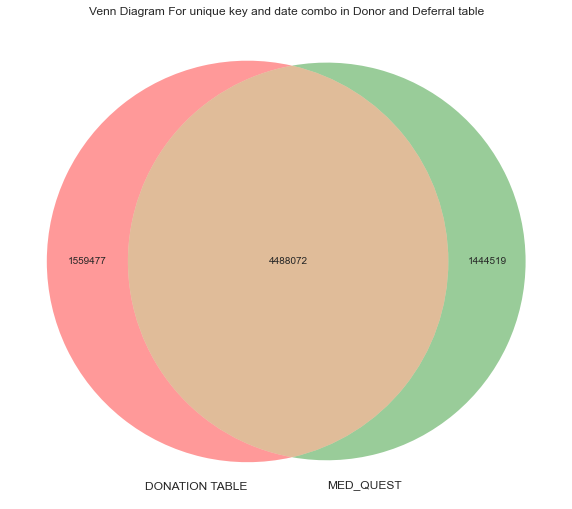

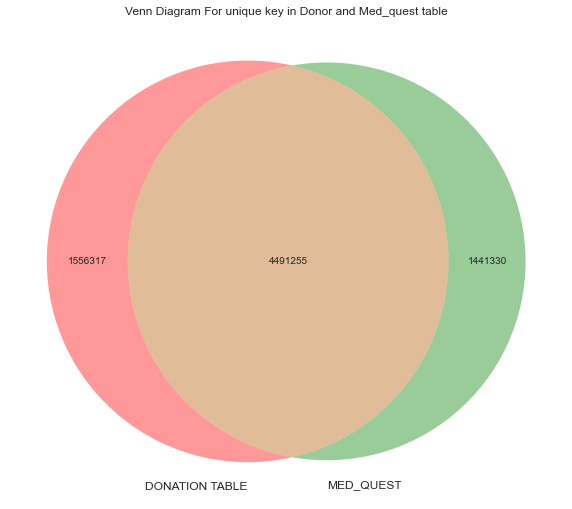

In [104]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3


plt.style.use('seaborn')
 

plt.figure(figsize=(10,10))
plt.title("Venn Diagram For unique key and date combo in Donor and Deferral table")

don['key_date'] = don['DONOR_NUMBER'].astype(str) +"-"+ don["DON_DATE_KEY"].astype(str)
m['key_date'] = m['DONOR_NUMBER_x'].astype(str) +"-"+ m["DON_DATE_KEY_x"].astype(str)


 
venn2([set(don["key_date"].to_list()), 
       set(m["key_date"].to_list())],
       set_labels=('DONATION TABLE', 'MED_QUEST')
     )
 
plt.show()

plt.figure(figsize=(10,10))
plt.title("Venn Diagram For unique key in Donor and Med_quest table")

venn2([set(don["DONATION_NUMBER"].to_list()), 
       set(m["DONATION_NUMBER"].to_list())],
       set_labels=('DONATION TABLE', 'MED_QUEST')
     )
 
plt.show()
